<a href="https://colab.research.google.com/github/sebanema/fast-ai/blob/main/01_Intro_sandbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [47]:
#hide
from fastbook import *

In [48]:
 #setup
 !pip install -U fastai ddgs primp fasttransform --no-deps

In [49]:
#setup process to import images
from ddgs import DDGS #DuckDuckGo has changed the api so we need to update
from fastcore.all import *

def search_images(keywords, max_images=200): return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')
import time, json

In [50]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('skyscraper photos', max_images=1)
urls[0]

'https://www.mmarchitecturalphotography.com/chicago-architectural-photographer/uploads/2018/05/chicago-commercial-photographer-skyscrapers-buildings-night.jpg'

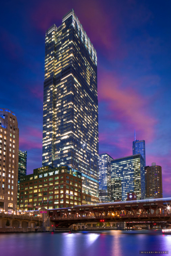

In [51]:
#download image
from fastdownload import download_url
dest = 'skyscraper.jpg'
download_url(urls[0], dest, show_progress=True)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

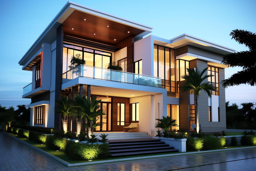

In [52]:
#download images
download_url(search_images('house photos', max_images=1)[0], 'house.jpg', show_progress=False)
Image.open('house.jpg').to_thumb(256,256)

In [53]:
#Download bulk images for training
searches = 'skyscraper', 'house'
path = Path('skyscraper_or_not')

for o in searches:
  dest = (path/o)
  dest.mkdir(exist_ok=True, parents=True)
  download_images(dest, urls=search_images(f'{o} photo'))
  time.sleep(5)
  resize_images(path/o, max_size=400, dest=path/o)

In [54]:
#check failed images
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

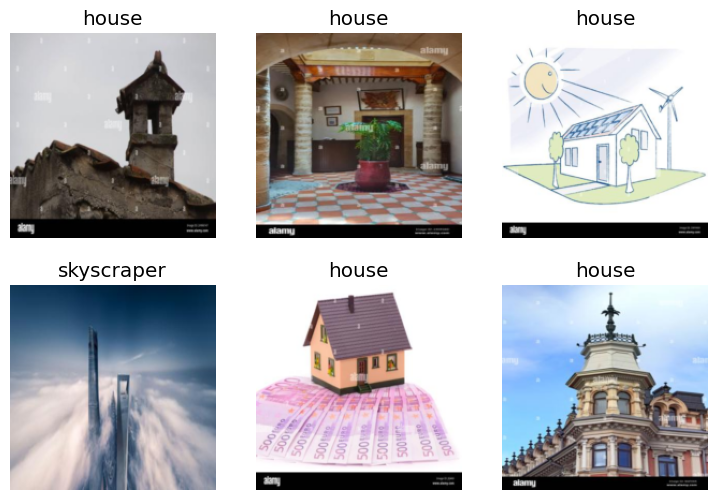

In [55]:
#defines how to transform your raw data into a format suitable for training
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [56]:
#train model
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,0.714842,0.095846,0.034483,00:43


epoch,train_loss,valid_loss,error_rate,time
0,0.075815,0.045419,0.008621,01:09
1,0.053328,0.047878,0.008621,01:05
2,0.031404,0.031148,0.008621,01:03


In [57]:
#Evaluate
is_skyscraper,_,probs = learn.predict(PILImage.create('skyscraper.jpg'))
print(f"This is a: {is_skyscraper}.")
print(f"Probability it's a skyscraper: {probs[0]:.4f}")

This is a: skyscraper.
Probability it's a skyscraper: 0.0001


In [58]:
uploader = widgets.FileUpload()
uploader

FileUpload(value={}, description='Upload')

In [62]:
import glob

drive.mount('/content/drive')
matches = glob.glob('/content/drive/MyDrive/**/01_skyscraper.jpeg', recursive=True)
print(matches)  # all matching paths

img = PILImage.create(matches[0])  # take the first match
is_skyscraper, _, probs = learn.predict(img)
print(f"Is this a skyscraper?: {is_skyscraper}")
print(f"Probability it's a skyscraper: {probs[1]:.6f}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['/content/drive/MyDrive/Colab Notebooks/01_skyscraper.jpeg']


Is this a skyscraper?: skyscraper
Probability it's a skyscraper: 0.999991
